<a href="https://colab.research.google.com/github/RanjKsan/Cyberbullying-detection-using-Transformer-model-and-XAI/blob/main/Ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AlbertForSequenceClassification, RobertaForSequenceClassification,
                          DistilBertForSequenceClassification, Trainer, TrainingArguments)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv("/content/cyberbullying_tweets.csv")

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df["cyberbullying_type"] = label_encoder.fit_transform(df["cyberbullying_type"])

# Split dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df["tweet_text"], df["cyberbullying_type"], test_size=0.2, random_state=42
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)


In [ ]:
# Define a Dataset class for tokenization
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
# Load separate tokenizers
tokenizer_albert = AutoTokenizer.from_pretrained("albert-base-v2")
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Create dataset objects
train_dataset_albert = CyberbullyingDataset(X_train, y_train, tokenizer_albert)
val_dataset_albert = CyberbullyingDataset(X_val, y_val, tokenizer_albert)

train_dataset_roberta = CyberbullyingDataset(X_train, y_train, tokenizer_roberta)
val_dataset_roberta = CyberbullyingDataset(X_val, y_val, tokenizer_roberta)

train_dataset_distilbert = CyberbullyingDataset(X_train, y_train, tokenizer_distilbert)
val_dataset_distilbert = CyberbullyingDataset(X_val, y_val, tokenizer_distilbert)

In [ ]:
# Load pretrained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_albert = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(label_encoder.classes_)).to(device)
model_roberta = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_)).to(device)
model_distilbert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_)).to(device)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

In [ ]:
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# Define function to compute metrics
def compute_metrics(p):
    pred, labels = p
    preds = pred.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_combined",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_combined",
    logging_steps=10,
    load_best_model_at_end=True
)

# Train each model
trainer_albert = Trainer(model=model_albert, args=training_args, train_dataset=train_dataset_albert, eval_dataset=val_dataset_albert, compute_metrics=compute_metrics)
trainer_roberta = Trainer(model=model_roberta, args=training_args, train_dataset=train_dataset_roberta, eval_dataset=val_dataset_roberta, compute_metrics=compute_metrics)
trainer_distilbert = Trainer(model=model_distilbert, args=training_args, train_dataset=train_dataset_distilbert, eval_dataset=val_dataset_distilbert, compute_metrics=compute_metrics)

trainer_albert.train()
trainer_roberta.train()
trainer_distilbert.train()

clear_memory()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chaennie1880 (chaennie1880-c) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
# Ensemble predictions
models = [model_albert, model_roberta, model_distilbert]
tokenizers = [tokenizer_albert, tokenizer_roberta, tokenizer_distilbert]

In [ ]:
# Prepare test dataset
test_dataset = CyberbullyingDataset(X_test, y_test, tokenizer_albert)  # Any tokenizer can be used here
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def get_ensemble_predictions(models, tokenizers, texts):
    final_preds = []
    for text in texts:
        logits_list = []
        for model, tokenizer in zip(models, tokenizers):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
            with torch.no_grad():
                logits = model(**inputs).logits
                logits_list.append(logits.cpu().numpy())

        avg_logits = sum(logits_list) / len(models)
        final_preds.append(avg_logits.argmax(axis=1)[0])
    return final_preds

# Get ensemble predictions
ensemble_preds = get_ensemble_predictions(models, tokenizers, X_test.tolist())

In [ ]:
import pandas as pd

# Compute final ensemble metrics
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_precision = precision_score(y_test, ensemble_preds, average='weighted')
ensemble_recall = recall_score(y_test, ensemble_preds, average='weighted')
ensemble_f1 = f1_score(y_test, ensemble_preds, average='weighted')

# Create a DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]
})

# Print the table
print("\n===== Ensemble Model Metrics =====")
print(metrics_df.to_string(index=False))



===== Ensemble Model Metrics =====
   Metric    Value
 Accuracy 0.869169
Precision 0.873211
   Recall 0.869169
 F1 Score 0.868851


**SHAP**

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=02bf19c641fc5156eca1a96e3e2620c6258c4666ab4a9def0e68b5aba787f21c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
def predict_proba_ensemble(texts):
    """
    Function to return ensemble class probabilities for LIME.
    """
    models = [model_albert, model_roberta, model_distilbert]  # List of models
    tokenizers = [tokenizer_albert, tokenizer_roberta, tokenizer_distilbert]  # List of tokenizers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_probs = []

    for model, tokenizer in zip(models, tokenizers):
        encoded_inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoded_inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

        all_probs.append(probs)

    # Compute the average probabilities across all models
    avg_probs = np.mean(all_probs, axis=0)

    return avg_probs

clear_memory()


🔷 **LIME Explanation for Ensemble Model** 🔷


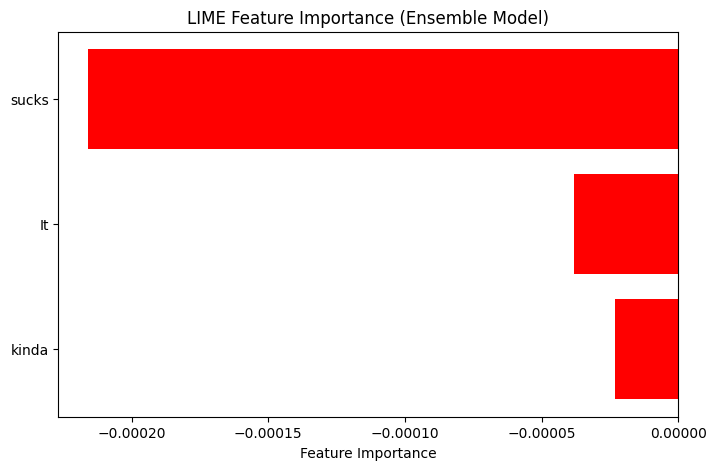


🔹 **Class Probabilities:**
  0: 0.0028
  1: 0.0008
  2: 0.0147
  3: 0.2009
  4: 0.7798
  5: 0.0010

🔹 **Local Explanation:**
  sucks: 🔴 Negative (-0.0002)
  It: 🔴 Negative (-0.0000)
  kinda: 🔴 Negative (-0.0000)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer

def explain_with_lime_ensemble(text_sample):
    """
    Apply LIME to the ensemble model and visualize results.
    """
    class_names = label_encoder.classes_  # Get class labels

    # Initialize LIME explainer
    explainer = LimeTextExplainer(class_names=class_names)

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        text_sample,
        predict_proba_ensemble,
        num_features=10,
        num_samples=100
    )

    # **1️⃣ Feature Importance: Bar Plot**
    weights = dict(explanation.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance (Ensemble Model)")
    plt.gca().invert_yaxis()
    plt.show()

    # **2️⃣ Class Probability Scores**
    probabilities = predict_proba_ensemble([text_sample])[0]
    print("\n🔹 **Class Probabilities:**")
    for i, label in enumerate(class_names):
        print(f"  {label}: {probabilities[i]:.4f}")

    # **3️⃣ Local Explanation (Word Contributions)**
    print("\n🔹 **Local Explanation:**")
    for word, weight in weights.items():
        impact = "🟢 Positive" if weight > 0 else "🔴 Negative"
        print(f"  {word}: {impact} ({weight:.4f})")

    # **4️⃣ Highlighted Text (Notebook Display)**
    return explanation.show_in_notebook()
# Select a random test sample
random_idx = np.random.randint(0, len(X_test))
sample_text = X_test.iloc[random_idx]

print("\n🔷 **LIME Explanation for Ensemble Model** 🔷")
explain_with_lime_ensemble(sample_text)
clear_memory()

In [ ]:
import numpy as np
import torch
from lime.lime_text import LimeTextExplainer

# Function to predict probabilities for the ensemble model
def predict_proba_ensemble(texts):
    models = [model_albert, model_roberta, model_distilbert]  # List of models
    tokenizers = [tokenizer_albert, tokenizer_roberta, tokenizer_distilbert]  # List of tokenizers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_probs = []

    for model, tokenizer in zip(models, tokenizers):
        encoded_inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoded_inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

        all_probs.append(probs)

    # Compute the average probabilities across all models
    avg_probs = np.mean(all_probs, axis=0)
    return avg_probs

# Function to compute fidelity score and local prediction
def compute_lime_fidelity_local_prediction(text_sample):
    class_names = label_encoder.classes_  # Get class labels
    explainer = LimeTextExplainer(class_names=class_names)

    # Generate LIME explanation
    explanation = explainer.explain_instance(
    text_sample,
    predict_proba_ensemble,
    num_features=15,  # More features for better representation
    num_samples=500  # More perturbation samples
)

    # 🔷 **Target Class Label**
    target_label = explanation.available_labels()[0]

    # 1️⃣ **Intercept & Feature Contributions**
    print(f"Intercept for label {target_label}: {explanation.intercept[target_label]:.4f}\n")
    print(f"Feature Contributions for label {target_label}:")

    # explanation.local_exp maps label index to (feature_index, weight) tuples
    local_prediction = explanation.intercept[target_label]

    for feature, weight in explanation.local_exp[target_label]:
        # Use the word() method to get the word from the IndexedString
        word = explanation.domain_mapper.indexed_string.word(feature)
        print(f"  {word}: {weight:.4f}")
        local_prediction += weight  # Summing feature contributions

    # 2️⃣ **Local Prediction**
    print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

    # 3️⃣ **Local Fidelity (R² Score)**

    if hasattr(explanation, "score") and explanation.score is not None:
        print(f"\nLocal Fidelity (R² Score): {explanation.score:.4f}")
    else:
        print("\nLocal Fidelity (R²) is not directly available in this explanation object.")

    return local_prediction, explanation.score

# Select a random test sample
random_idx = np.random.randint(0, len(X_test))
sample_text = X_test.iloc[random_idx]

# Compute Local Prediction and Fidelity Score
print("\n🔷 **LIME Fidelity & Local Prediction for Ensemble Model** 🔷")
local_pred, fidelity = compute_lime_fidelity_local_prediction(sample_text)
clear_memory()



🔷 **LIME Fidelity & Local Prediction for Ensemble Model** 🔷
Intercept for label 1: 0.0490

Feature Contributions for label 1:
  nigger: 0.7917
  dumb: 0.0995
  FOR: 0.0254
  OBAMA: 0.0252
  tayyoung_: 0.0229
  FORGIVENESS: -0.0173
  FUCK: 0.0169
  ass: 0.0120
  SHOULD: 0.0111
  TONIGHT: 0.0100
  PRAY: 0.0047
  YOU: 0.0041
  ASK: 0.0041

Local Prediction (Intercept + Sum of Feature Contributions): 1.0593

Local Fidelity (R² Score): 0.9581


**SHAP**

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 3/50 [00:23<01:02,  1.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:29<02:33,  3.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:34<03:03,  4.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:40<03:27,  4.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [00:56<01:49,  2.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [01:02<02:16,  3.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:09<02:53,  4.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:15<03:05,  5.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [01:27<03:01,  5.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [01:34<03:17,  5.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [01:42<03:30,  6.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [01:50<03:38,  7.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [02:11<02:02,  4.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [02:16<02:00,  4.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [02:24<02:15,  5.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [02:30<02:12,  5.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [02:35<02:02,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [02:40<01:54,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [02:47<02:01,  6.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [02:59<01:41,  5.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [03:05<01:37,  5.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [03:15<01:19,  5.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [03:22<01:24,  6.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [03:39<01:00,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [03:46<00:58,  5.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [03:52<00:53,  5.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [03:58<00:47,  6.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [04:10<00:35,  5.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [04:20<00:21,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [04:26<00:17,  5.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [04:33<00:04,  4.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [04:40,  5.60s/it]


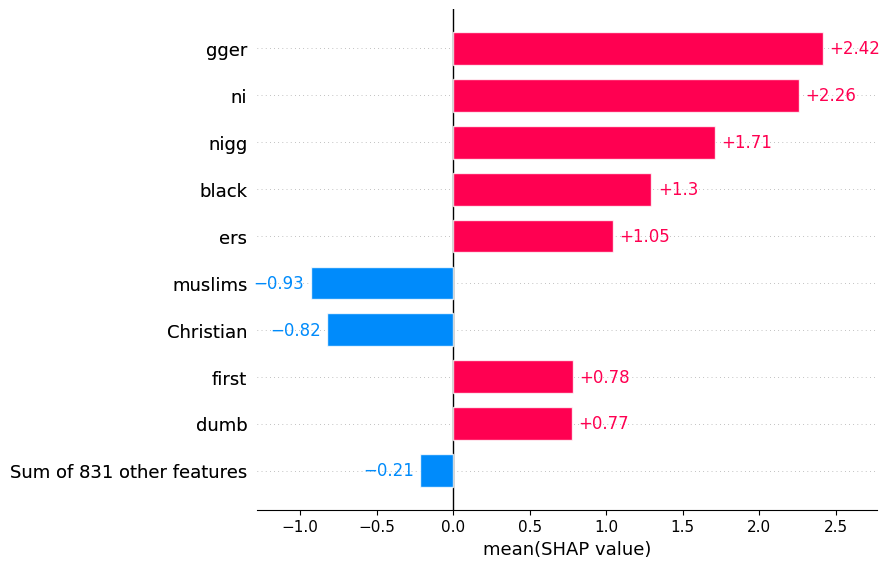

In [ ]:
import shap
import torch
import numpy as np

# Create a prediction function compatible with SHAP for the ensemble model
def predictor_ensemble(texts):
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize and process input for each model in the ensemble
    encodings = [tokenizer(
        [str(text) for text in texts],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ) for tokenizer in tokenizers]

    input_ids = [enc['input_ids'].to(device) for enc in encodings]
    attention_masks = [enc['attention_mask'].to(device) for enc in encodings]

    # Get predictions from each model
    predictions = []
    with torch.no_grad():
        for i, model in enumerate(models):
            outputs = model(input_ids[i], attention_mask=attention_masks[i])
            predictions.append(outputs.logits.cpu().numpy())

    # Average predictions (ensemble output)
    ensemble_logits = np.mean(predictions, axis=0)
    return ensemble_logits

# Initialize SHAP explainer
explainer_shap_ensemble = shap.Explainer(
    predictor_ensemble,
    masker=shap.maskers.Text(tokenizers[0]),  # Using first model's tokenizer
    output_names=label_encoder.classes_.tolist()
)

# Select a sample of texts to explain
sample_texts = X_val.sample(n=50, random_state=42).tolist()

# Compute SHAP values
shap_values_ensemble = explainer_shap_ensemble(sample_texts)

# Visualization 1: Force plot for individual predictions
shap.plots.text(shap_values_ensemble[0])

# Visualization 2: Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values_ensemble.mean(0)[:, 1])

torch.cuda.empty_cache()
clear_memory()

In [ ]:
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
import numpy as np
import shap
import torch

def compute_shap_fidelity_ensemble(explainer, texts, top_k=5, importance_threshold=0.02):
    """
    Computes fidelity score for SHAP explanations on the ensemble model.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        texts (list): List of texts to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.
        importance_threshold (float): Minimum SHAP importance required for masking.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Get original ensemble prediction
        orig_logits = predictor_ensemble([text])
        orig_probs = np.exp(orig_logits) / np.sum(np.exp(orig_logits), axis=1)  # Softmax
        orig_pred_prob = np.max(orig_probs)  # Highest probability class

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # **Filter tokens based on importance threshold**
        important_indices = np.where(token_importance > importance_threshold)[0]

        # Select the most important `top_k` tokens
        top_k_indices = important_indices[-top_k:] if len(important_indices) >= top_k else important_indices

        # Mask top-k tokens using first model's tokenizer
        tokenizer = tokenizers[0]  # Use the first tokenizer for consistency
        encoded_inputs = tokenizer(text, return_tensors="pt")
        masked_input_ids = encoded_inputs["input_ids"].clone().to(device)

        # Masking method: Replace high-impact words with "[MASK]"
        for idx in top_k_indices:
            masked_input_ids[0, idx] = tokenizer.mask_token_id  # Replace with [MASK]

        # Convert masked input back to text
        masked_text = tokenizer.decode(masked_input_ids[0], skip_special_tokens=True)

        # Get prediction on masked input
        masked_logits = predictor_ensemble([masked_text])
        masked_probs = np.exp(masked_logits) / np.sum(np.exp(masked_logits), axis=1)
        masked_pred_prob = np.max(masked_probs)

        # Compute fidelity score
        fidelity_score = 1 - abs(orig_pred_prob - masked_pred_prob) / orig_pred_prob
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores
sample_texts = X_val.sample(n=30, random_state=42).tolist()

# Compute Optimized Fidelity Score for the Ensemble Model
fidelity_score_ensemble = compute_shap_fidelity_ensemble(explainer_shap_ensemble, sample_texts, top_k=5, importance_threshold=0.02)
print("🔹 Optimized SHAP Fidelity Score for Ensemble Model:", fidelity_score_ensemble)

torch.cuda.empty_cache()
clear_memory()


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

🔹 Optimized SHAP Fidelity Score for Ensemble Model: 0.9238
